# 导入依赖

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

print(f"NumPy {np.__version__} imported" )
print(f"Pandas {pd.__version__} imported" )

NumPy 2.0.1 imported
Pandas 2.2.3 imported


# 下载数据集

In [2]:
# 读入数据集
train= pd.read_csv('data/train.csv')
test= pd.read_csv('data/test.csv')
# 复制数据避免修改原始数据
train_data = train.copy()
test_data = test.copy()
# 合并测试集和训练集以便于从全部数据总结特征
full_data = pd.concat([train_data,test_data],ignore_index=True)

# 删除不需要的列
full_data = full_data.drop(['Name', 'Ticket'], axis=1) 

In [3]:
full_data.head(8)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0.0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1.0,1,female,38.0,1,0,71.2833,C85,C
2,3,1.0,3,female,26.0,0,0,7.9250,NaN,S
3,4,1.0,1,female,35.0,1,0,53.1000,C123,S
4,5,0.0,3,male,35.0,0,0,8.0500,NaN,S
5,6,0.0,3,male,NaN,0,0,8.4583,NaN,Q
6,7,0.0,1,male,54.0,0,0,51.8625,E46,S
7,8,0.0,3,male,2.0,3,1,21.0750,NaN,S


# 数据清洗
**查找缺失值：**

In [4]:
full_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Sex               0
Age             263
SibSp             0
Parch             0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

观察到：  
Age，Embarked，Fare，Cabin有缺失值 （Survived是目标变量）

Embarked是**分类型**特征，直接用众数填充

In [5]:
# 用众数填充缺失的Embarked
full_data.fillna({'Embarked': full_data['Embarked'].mode()[0]}, inplace=True)

Fare是**数值型**特征，且它与Pclass关联性较强

In [6]:
# 查看缺失Fare的那行数据
full_data[full_data['Fare'].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
1043,1044,NaN,3,male,60.5,0,0,NaN,NaN,S


由于缺失Fare的数据的Pclass=3，所以我们用Pclass=3的数据的Fare的median来填充缺失

In [7]:
full_data.fillna({'Fare': full_data[full_data['Pclass'] == 3]['Fare'].median()}, inplace=True)

将Sex和Embarked数值化：

In [8]:
full_data['Sex'] = full_data['Sex'].map({'male': 0, 'female': 1})
full_data = pd.get_dummies(full_data, columns=['Embarked'], prefix='Emb')

用**随机森林**来预测并填充Age的缺失值:

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [10]:
# 创建随机森林填充器对象
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0), # 回归模型
    max_iter=10, # 最大迭代次数
    random_state=42, # 随机数种子
    verbose=2 # 显示日志
)

In [11]:
# 填充Age列中的缺失值
imputer.fit(full_data[['Age']])
full_data['Age'] = imputer.transform(full_data[['Age']])

Cabin的有无可能对存活结果有影响：

In [12]:
# 将Cabin转化为分类变量
full_data.loc[full_data['Cabin'].notnull(), 'Cabin'] = 1
full_data.loc[full_data['Cabin'].isnull(), 'Cabin'] = 0

现在，缺失值已经全部填充完毕!

# 特征工程
创建新特征：

In [13]:
# 创建新特征
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1
full_data['IsAlone'] = 0
full_data.loc[full_data['FamilySize'] == 1, 'IsAlone'] = 1

In [14]:
full_data.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin            0
Emb_C            0
Emb_Q            0
Emb_S            0
FamilySize       0
IsAlone          0
dtype: int64

将full_data重新拆分为训练集和测试集：

In [15]:
# 根据Survived列将数据重新分为训练集和测试集
train_data = full_data[full_data['Survived'].notnull()]
test_data = full_data[full_data['Survived'].isnull()]

将数据标准化：

In [16]:
from sklearn.preprocessing import StandardScaler # 标准化
scaler = StandardScaler()

train_data_X_scaled = scaler.fit(train_data.drop('Survived', axis=1)).transform(train_data.drop('Survived', axis=1))
train_data_X_scaled = pd.DataFrame(train_data_X_scaled, columns=train_data.drop('Survived', axis=1).columns)

test_data_X_scaled = scaler.fit(train_data.drop('Survived', axis=1)).transform(test_data.drop('Survived', axis=1))
test_data_X_scaled = pd.DataFrame(test_data_X_scaled, columns=test_data.drop('Survived', axis=1).columns)

导入各种模型以及评分函数：

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score

对模型拟合效果评分

In [18]:
models = [
    KNeighborsClassifier(3),
    LogisticRegression(random_state=0),
    GaussianNB(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    SVC(kernel="linear", C=0.025)
]

names=['KNN','LR','NB','Tree','RF','GDBT','SVM']
scores=[]
for name, model in zip(names, models):
    score=cross_val_score(model, train_data_X_scaled, train_data['Survived'], cv=5)
    scores.append(score.mean())
    print("{}:{},{}".format(name,score.mean(),score))

KNN:0.7789404306069926,[0.74301676 0.76404494 0.75280899 0.82022472 0.81460674]
LR:0.7968614650681062,[0.79329609 0.79775281 0.78651685 0.79775281 0.80898876]
NB:0.7464503169920281,[0.65921788 0.73595506 0.75842697 0.79775281 0.78089888]
Tree:0.754371979160128,[0.60893855 0.78651685 0.76966292 0.79775281 0.80898876]
RF:0.8025673215742891,[0.7150838  0.78651685 0.83707865 0.81460674 0.85955056]
GDBT:0.7779612077082418,[0.61452514 0.80898876 0.8258427  0.79775281 0.84269663]
SVM:0.7878601468834348,[0.80446927 0.80898876 0.78651685 0.75280899 0.78651685]


In [19]:
# 选择模型
choice = str(input("请选择模型："))
if choice == 'RF':
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=7,
        min_samples_split=6,
        random_state=42
    )
elif choice == 'LR':
    model = LogisticRegression(random_state=0)
elif choice == 'KNN':
    model = KNeighborsClassifier(3)
elif choice == 'Tree':
    model = DecisionTreeClassifier(random_state=0)
elif choice == 'NB':
    model = GaussianNB()
elif choice == 'SVM':
    model = SVC(kernel="linear", C=0.025)
elif choice == 'GDBT':
    model = GradientBoostingClassifier(random_state=0)
else:
    print("输入错误，请重新输入")
    exit()
# 训练模型
model.fit(train_data_X_scaled, train_data['Survived'])

# 训练模型
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_split=6,
    random_state=42
)
model.fit(train_data_X_scaled, train_data['Survived'])

# 预测测试集
predictions = model.predict(test_data_X_scaled)
predictions = predictions.astype(int) # float64转int

请选择模型： RF


In [20]:
predictions[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [21]:
# 保存结果
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": predictions
    })
submission.to_csv('submission_demo1.csv', index=False)
print("结果已保存到：submission_demo1.csv")

结果已保存到：submission_demo1.csv


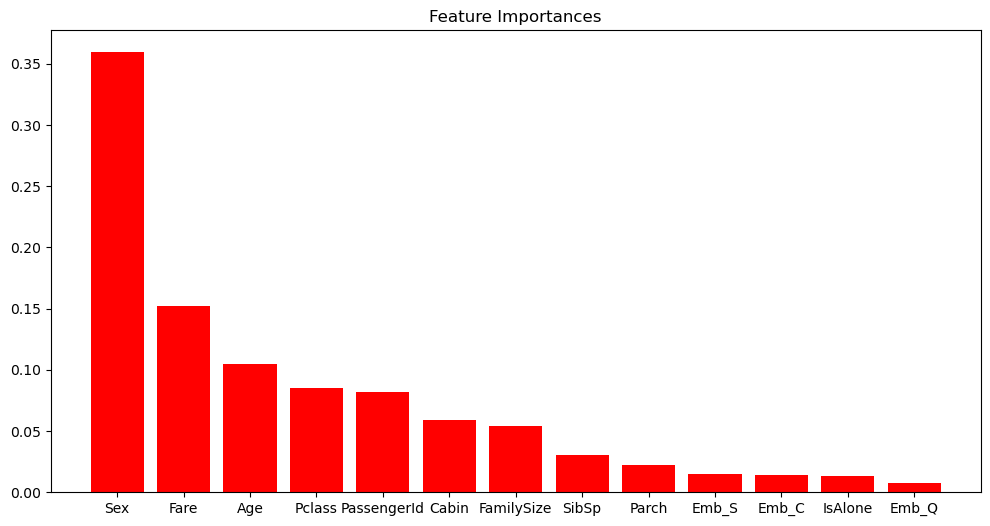

In [22]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importances")
plt.bar(range(train_data_X_scaled.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(train_data_X_scaled.shape[1]), train_data_X_scaled.columns[indices])
plt.xlim([-1, train_data_X_scaled.shape[1]])
plt.show()